In [110]:
import pickle
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from keras.models import Sequential 
from keras.layers import Dense, Activation
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from keras import backend as K


In [111]:
Sentences = []
with open("processed_data.dat", "rb") as f:
    Sentences = pickle.load(f)

In [112]:
attributes = ['is_argument', 'arg_class', 'd_rel', 'phrase_type', 'predicate_pos', 'drel_pos']
dt = pd.DataFrame(columns = attributes)

In [115]:
all_data = {
    'is_argument' : [],
    'arg_class' : [],
    'd_rel' : [],
    'phrase_type' : [],
    'predicate_pos' : [],
    'drel_pos': []
}
for sentence in tqdm(Sentences):
    for chunk in sentence.nodeList:
#         print(chunk.__dict__)
#         data_entry = dict()
        if chunk.parentPB != '0':
            all_data['is_argument'].append(True)
            all_data['arg_class'].append(chunk.parentPBRelation)
        else:
            all_data['is_argument'].append(False)
            all_data['arg_class'].append(np.NaN)
        all_data['d_rel'].append(chunk.parentRelation)
        all_data['phrase_type'].append(chunk.type)
        all_data['predicate_pos'].append(chunk.parentPB)
        all_data['drel_pos'].append(f"{chunk.parentRelation}:{chunk.parentPB}")
#         print(data_entry)
dt = dt.append(pd.DataFrame(all_data))
dt

100%|██████████| 6796/6796 [00:00<00:00, 23230.46it/s]


,is_argument,arg_class,d_rel,phrase_type,predicate_pos,drel_pos
0,False,NaN,ccof,NP,0,ccof:0
1,True,ARG0-GOL,k4a,CCP,VGF,k4a:VGF
2,False,NaN,nmod,NP,0,nmod:0
3,False,NaN,ccof,NP,0,ccof:0
4,True,ARGM-TMP,k7t,NP,VGF,k7t:VGF
...,...,...,...,...,...,...
101561,False,NaN,pof,JJP,0,pof:0
101562,False,NaN,r6,VGNN,0,r6:0
101563,False,NaN,ccof,NP,0,ccof:0
101564,False,NaN,k1s,JJP,0,k1s:0


### Argument Identification

In [116]:
dataset = dt.values
X = dataset[:, 2:-1]
y = dataset[:,0]
X = X.astype(str)
y = y.reshape((len(y), 1))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
print('Train', X_train.shape, y_train.shape)
print('Test', X_test.shape, y_test.shape)

Train (81252, 3) (81252, 1)
Test (20314, 3) (20314, 1)


In [117]:
# prepare input data
def prepare_inputs(X,X_train, X_test):
    ohe = OneHotEncoder()
    ohe.fit(X)
    X_train_enc = ohe.transform(X_train)
    X_test_enc = ohe.transform(X_test)
    return X_train_enc, X_test_enc
 
# prepare target
def prepare_targets(y_train, y_test):
    le = LabelEncoder()
    le.fit(y_train)
    y_train_enc = le.transform(y_train)
    y_test_enc = le.transform(y_test)
    return y_train_enc, y_test_enc

X_train_enc, X_test_enc = prepare_inputs(X,X_train, X_test)
y_train_enc, y_test_enc = prepare_targets(y_train, y_test)
print('Train', X_train_enc.shape, y_train_enc.shape)
print('Test', X_test_enc.shape, y_test_enc.shape)

Train (81252, 156) (81252,)
Test (20314, 156) (20314,)


/home/akshatcx/.virtualenvs/nlp/lib/python3.6/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/akshatcx/.virtualenvs/nlp/lib/python3.6/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [118]:
# model = Sequential() 
# model.add(Dense(2, input_dim=input_dim, activation='softmax'))
model = Sequential()
model.add(Dense(10, input_dim=X_train_enc.shape[1], activation='relu', kernel_initializer='he_normal'))
model.add(Dense(1, activation='sigmoid'))
# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# fit the keras model on the dataset
model.fit(X_train_enc, y_train_enc, epochs=15, batch_size=16, verbose=2)
# evaluate the keras model
_, accuracy = model.evaluate(X_test_enc, y_test_enc, verbose=0)
print('Accuracy: %.2f' % (accuracy*100))
print(model.summary())

Epoch 1/15
 - 9s - loss: 0.0485 - accuracy: 0.9908
Epoch 2/15
 - 6s - loss: 1.1978e-04 - accuracy: 1.0000
Epoch 3/15
 - 5s - loss: 6.6009e-06 - accuracy: 1.0000
Epoch 4/15
 - 10s - loss: 4.5664e-07 - accuracy: 1.0000
Epoch 5/15
 - 6s - loss: 3.8092e-08 - accuracy: 1.0000
Epoch 6/15
 - 5s - loss: 5.0266e-09 - accuracy: 1.0000
Epoch 7/15
 - 11s - loss: 1.4709e-09 - accuracy: 1.0000
Epoch 8/15
 - 5s - loss: 7.9022e-10 - accuracy: 1.0000
Epoch 9/15
 - 7s - loss: 5.3575e-10 - accuracy: 1.0000
Epoch 10/15
 - 9s - loss: 4.1203e-10 - accuracy: 1.0000
Epoch 11/15
 - 7s - loss: 3.3145e-10 - accuracy: 1.0000
Epoch 12/15
 - 11s - loss: 2.8543e-10 - accuracy: 1.0000
Epoch 13/15
 - 6s - loss: 2.4444e-10 - accuracy: 1.0000
Epoch 14/15
 - 5s - loss: 2.1567e-10 - accuracy: 1.0000
Epoch 15/15
 - 10s - loss: 1.9539e-10 - accuracy: 1.0000
Accuracy: 100.00
Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param # 

### Semantic Role Classifier

In [119]:
dt_arguments =  dt[dt['arg_class'].notnull()]
dataset = dt_arguments.values
X = dataset[:, 2:]
y = dataset[:,1]
X = X.astype(str)
y = y.reshape((len(y), 1))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
print('Train', X_train.shape, y_train.shape)
print('Test', X_test.shape, y_test.shape)

Train (26360, 4) (26360, 1)
Test (6591, 4) (6591, 1)


In [120]:
X_train_enc, X_test_enc = prepare_inputs(X,X_train, X_test)
y_train_enc, y_test_enc = prepare_inputs(y,y_train, y_test)
print('Train', X_train_enc.shape, y_train_enc.shape)
print('Test', X_test_enc.shape, y_test_enc.shape)

Train (26360, 1192) (26360, 22)
Test (6591, 1192) (6591, 22)


In [121]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [122]:
model2 = Sequential()
model2.add(Dense(10, input_dim=X_train_enc.shape[1], activation='relu', kernel_initializer='he_normal'))
model2.add(Dense(y_train_enc.shape[1], activation='softmax'))
# compile the keras model
model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', recall_m, f1_m, precision_m])
# fit the keras model on the dataset
model2.fit(X_train_enc, y_train_enc, epochs=20, batch_size=16, verbose=2)

Epoch 1/20
 - 2s - loss: 1.2027 - accuracy: 0.6663 - recall_m: 0.4849 - f1_m: 0.5743 - precision_m: 0.7712
Epoch 2/20
 - 2s - loss: 0.6398 - accuracy: 0.8208 - recall_m: 0.7832 - f1_m: 0.8137 - precision_m: 0.8493
Epoch 3/20
 - 2s - loss: 0.5833 - accuracy: 0.8248 - recall_m: 0.8040 - f1_m: 0.8250 - precision_m: 0.8489
Epoch 4/20
 - 4s - loss: 0.5579 - accuracy: 0.8307 - recall_m: 0.8104 - f1_m: 0.8284 - precision_m: 0.8488
Epoch 5/20
 - 4s - loss: 0.5419 - accuracy: 0.8320 - recall_m: 0.8138 - f1_m: 0.8312 - precision_m: 0.8508
Epoch 6/20
 - 4s - loss: 0.5309 - accuracy: 0.8342 - recall_m: 0.8138 - f1_m: 0.8319 - precision_m: 0.8524
Epoch 7/20
 - 2s - loss: 0.5232 - accuracy: 0.8353 - recall_m: 0.8167 - f1_m: 0.8336 - precision_m: 0.8526
Epoch 8/20
 - 2s - loss: 0.5168 - accuracy: 0.8357 - recall_m: 0.8150 - f1_m: 0.8331 - precision_m: 0.8536
Epoch 9/20
 - 2s - loss: 0.5121 - accuracy: 0.8372 - recall_m: 0.8181 - f1_m: 0.8347 - precision_m: 0.8532
Epoch 10/20
 - 2s - loss: 0.5080 - ac

## Results

/home/akshatcx/.virtualenvs/nlp/lib/python3.6/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/akshatcx/.virtualenvs/nlp/lib/python3.6/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Confusion Matrix:


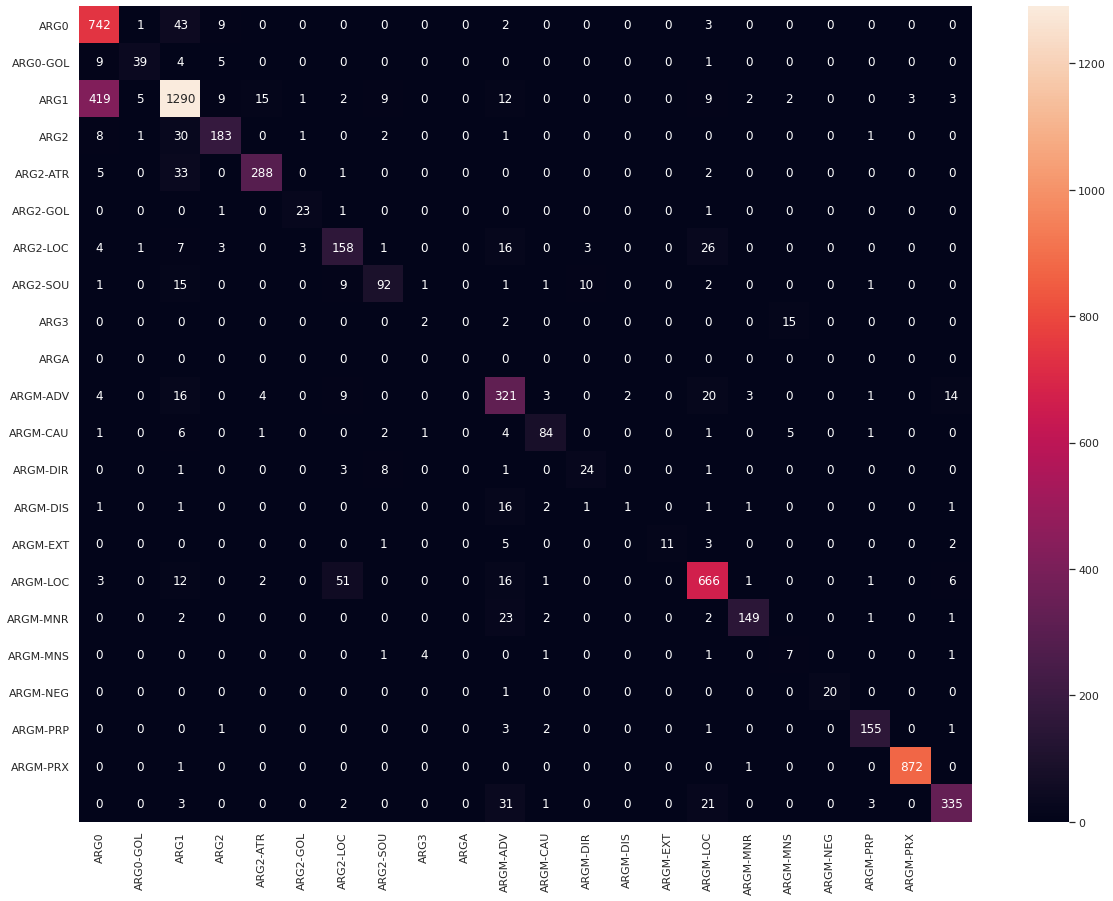

In [123]:
# Confusion Matrix

y_pred_enc = model2.predict_classes(X_test_enc)

le = LabelEncoder()
le.fit(y_train)
y_test_a = le.transform(y_test)
labels = le.inverse_transform([i for i in range(21)])

con_mat = tf.math.confusion_matrix(labels=y_test_a, predictions=y_pred_enc).numpy()

plt.subplots(figsize=(20,15))
sns.set()
confusion_matrix = sns.heatmap(con_mat, annot=True, xticklabels=labels, yticklabels=labels, fmt='g')
print("Confusion Matrix:")


In [125]:
loss, accuracy, recall, f1_score, precision = model2.evaluate(X_test_enc, y_test_enc, verbose=0)
print("Scores:")
print(f"Accuracy: {accuracy}\nPrecision: {precision}\nRecall: {recall}\nF1-score: {f1_score}\nLoss: {loss}\n")
print(model2.summary())

Scores:
Accuracy: 0.8287057876586914
Precision: 0.8617866039276123
Recall: 0.7869901061058044
F1-score: 0.8220494389533997
Loss: 0.623884641993952

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_29 (Dense)             (None, 10)                11930     
_________________________________________________________________
dense_30 (Dense)             (None, 22)                242       
Total params: 12,172
Trainable params: 12,172
Non-trainable params: 0
_________________________________________________________________
None


In [126]:
!mkdir -p saved_models
model.save('saved_models/identification_model')
model2.save('saved_models/classification_model')